<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/3_autoencoder_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

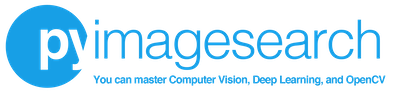

# Anomaly detection with Keras, TensorFlow, and Deep Learning
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Anomaly detection with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/) blog post published on 2020-03-02.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install the necessary packages

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 2.9 MB 35.5 MB/s 
     |████████████████████████████████| 454 kB 50.4 MB/s 
     |████████████████████████████████| 3.0 MB 16.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

### Download the code zip file

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-autoencoder-anomaly-detection/autoencoder-anomaly-detection.zip
!unzip -qq autoencoder-anomaly-detection.zip
%cd autoencoder-anomaly-detection

--2021-08-26 09:37:54--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-autoencoder-anomaly-detection/autoencoder-anomaly-detection.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.184.16
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.184.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3169538 (3.0M) [application/zip]
Saving to: ‘autoencoder-anomaly-detection.zip’

autoencoder-anomaly 100%[===================>]   3.02M  3.21MB/s    in 0.9s    

2021-08-26 09:37:56 (3.21 MB/s) - ‘autoencoder-anomaly-detection.zip’ saved [3169538/3169538]

/content/autoencoder-anomaly-detection


## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our autoencoder for anomaly detection with Keras and TensorFlow

In [5]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### Implementing the anomaly detection training script

In [6]:
def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	# return the set of images
	return images

In [7]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [8]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#	help="path to output dataset file")
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to output trained autoencoder")
#ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
#	help="path to output reconstruction visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"vis": "recon_vis.png",
	"plot": "plot.png"	
}

In [9]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] creating unsupervised dataset...


[INFO] building autoencoder...
Epoch 1/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0435 - val_loss: 0.0440
Epoch 2/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0094 - val_loss: 0.0297
Epoch 3/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 9/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/20
171/171 [==============================] - 1s 6ms/step - 

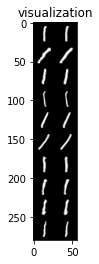

In [10]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args["vis"], vis)
plt_imshow("visualization", vis)

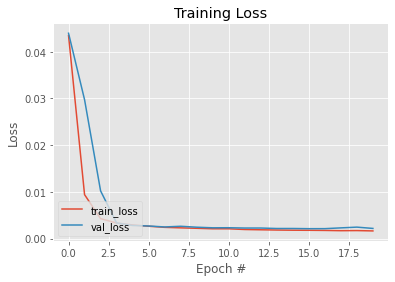

[INFO] saving image data...
[INFO] saving autoencoder...


In [11]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

# serialize the image data to disk
print("[INFO] saving image data...")
f = open(args["dataset"], "wb")
f.write(pickle.dumps(images))
f.close()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"], save_format="h5")

### Implementing our script to find anomalies/outliers using the autoencoder

In [12]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#	help="path to input image dataset file")
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-q", "--quantile", type=float, default=0.999,
#	help="q-th quantile used to identify outliers")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"quantile": 0.999	
}

In [13]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
autoencoder = load_model(args["model"])
images = pickle.loads(open(args["dataset"], "rb").read())

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

[INFO] loading autoencoder and image data...


In [14]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, args["quantile"])
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.024886289969086654
[INFO] 7 outliers found


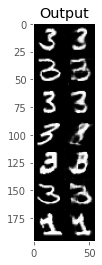

In [15]:
# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (images[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt_imshow("Output", outputs)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Anomaly detection with Keras, TensorFlow, and Deep Learning*](https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/) published on 2020-03-02.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```